# Image Resizing and Enhancement


A short notebook where we resized dermatoscopic images

This block resizes and compresses all .jpg/.jpeg images in a specified input directory to 224x224 resolution and stores them in a new folder.

In [ ]:
import os
from PIL import Image

# Configuration
input_dir = "/content"
output_size = (224, 224)
quality = 70

# Output directory
output_dir = os.path.join(input_dir, "compressed_224x224_jpg")
os.makedirs(output_dir, exist_ok=True)

# Loop through all JPEG files
for filename in os.listdir(input_dir):
    if not filename.lower().endswith((".jpg", ".jpeg")):
        continue

    filepath = os.path.join(input_dir, filename)
    img = Image.open(filepath).convert("RGB")


    img_resized = img.resize(output_size, Image.LANCZOS)


    name, _ = os.path.splitext(filename)
    out_path = os.path.join(output_dir, name + ".jpg")
    img_resized.save(out_path, format="JPEG", quality=quality, optimize=True)

    print(f"Compressed and resized {filename} -> {out_path}")


In [ ]:
import torch

torch.device('cuda')

device(type='cuda')

## Function to Resize Images by Fixed Height with Optional Padding

This functionr esizes all .jpg/.jpeg images in a directory by fixing their height while preserving the original aspect ratio. Optionally, it can pad the images into a square canvas

In [19]:
from PIL import Image
import os

def resize_images_with_fixed_height(
    input_dir: str,
    output_dir: str,
    fixed_size: int = 224,
    quality: int = 100,
    pad_to_square: bool = True,
    padding_color=(31, 55, 25)
):
    os.makedirs(output_dir, exist_ok=True)

    for filename in os.listdir(input_dir):
        if not filename.lower().endswith((".jpg", ".jpeg")):
            continue

        filepath = os.path.join(input_dir, filename)
        img = Image.open(filepath).convert("RGB")

        # Resize to fit within fixed_size x fixed_size while preserving aspect ratio
        img.thumbnail((fixed_size, fixed_size), Image.LANCZOS)  # Aspect ratio preserved

        if pad_to_square:
            # Create square canvas and paste resized image at center
            canvas = Image.new("RGB", (fixed_size, fixed_size), padding_color)
            paste_x = (fixed_size - img.size[0]) // 2
            paste_y = (fixed_size - img.size[1]) // 2
            canvas.paste(img, (paste_x, paste_y))
            final_img = canvas
        else:
            final_img = img

        # Save result
        name, _ = os.path.splitext(filename)
        out_path = os.path.join(output_dir, name + ".jpg")
        final_img.save(out_path, format="JPEG", quality=quality, optimize=True)

        print(f"{filename}: resized to {img.size}, saved -> {out_path}")


In [20]:
resize_images_with_fixed_height("/content/proba/","/content/proba_resized/",pad_to_square=True )

ISIC_9758444.jpg: resized to (224, 149), saved -> /content/proba_resized/ISIC_9758444.jpg
ISIC_0452656.jpg: resized to (224, 168), saved -> /content/proba_resized/ISIC_0452656.jpg


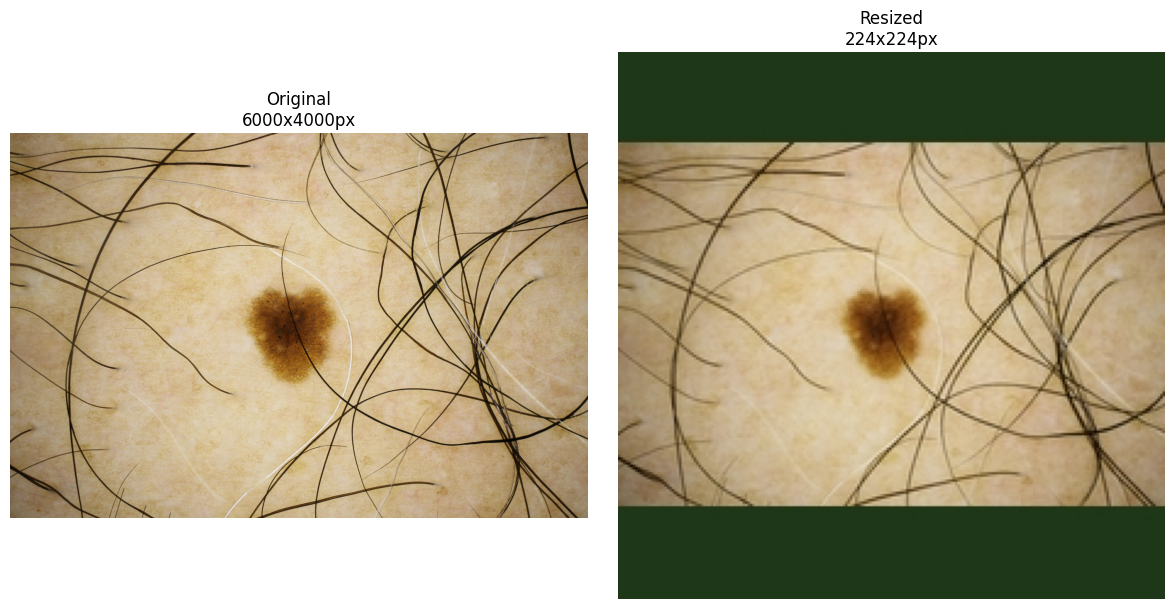

In [29]:
show_images("/content/proba/ISIC_9758444.jpg", "/content/proba_resized/ISIC_9758444.jpg",title2='Resized')

## Image enhancement using CLAHE

This code applies Contrast Limited Adaptive Histogram Equalization (CLAHE) to improve the contrast of an image. Improving contrast before feeding dermatoscopic images into a classifier or segmentation model often helps with better edge visibility, highlighting lesion texture and improved feature extraction.

In [ ]:
import cv2
import os

def apply_clahe_to_image(
    input_path: str,
    output_path: str,
    clip_limit: float = 1.0,
    tile_grid_size: tuple = (8, 8)
) -> None:
    """
    Applies CLAHE to the L channel of a LAB image and saves the result.

    Parameters:
    - input_path (str): Path to the input image.
    - output_path (str): Path to save the enhanced image.
    - clip_limit (float): Contrast limiting threshold for CLAHE.
    - tile_grid_size (tuple): Size of grid for histogram equalization.
    """
    image = cv2.imread(input_path)
    if image is None:
        raise FileNotFoundError(f"Could not load image: {input_path}")

    # Convert BGR to LAB
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    l_channel, a_channel, b_channel = cv2.split(lab)

    # Apply CLAHE to L channel
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    l_clahe = clahe.apply(l_channel)

    # Merge channels and convert back to BGR
    lab_clahe = cv2.merge((l_clahe, a_channel, b_channel))
    enhanced_image = cv2.cvtColor(lab_clahe, cv2.COLOR_LAB2BGR)

    # Save enhanced image
    cv2.imwrite(output_path, enhanced_image)
    print(f"Saved enhanced image to: {output_path}")


In [27]:
input_image = "/content/ISIC_9758444.jpg"
output_image = "/content/ISIC_9758444_enhanced.jpg"

Saved enhanced image to: /content/ISIC_9758444_enhanced.jpg


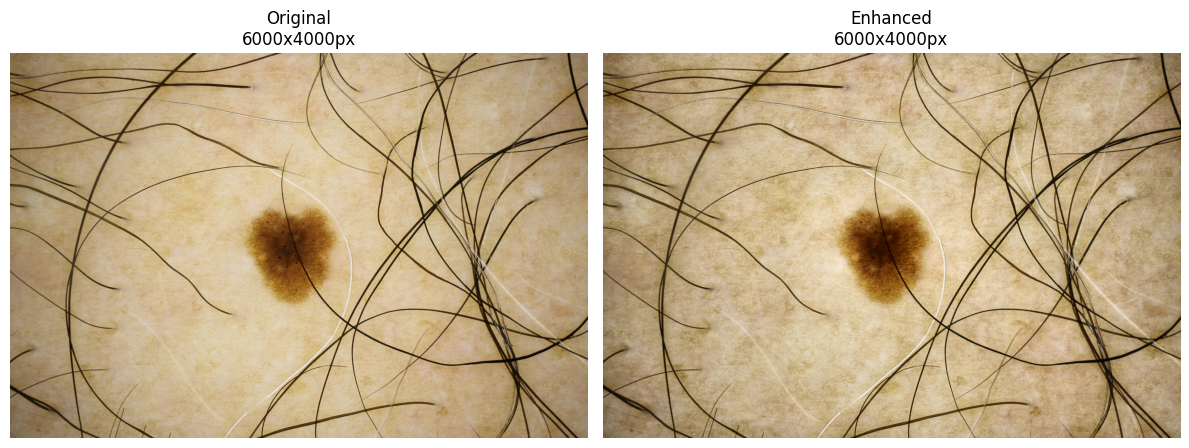

In [28]:
apply_clahe_to_image(input_image, output_image,clip_limit=1)
show_images(input_image, output_image)

Saved enhanced image to: /content/ISIC_0452656_enhanced.jpg


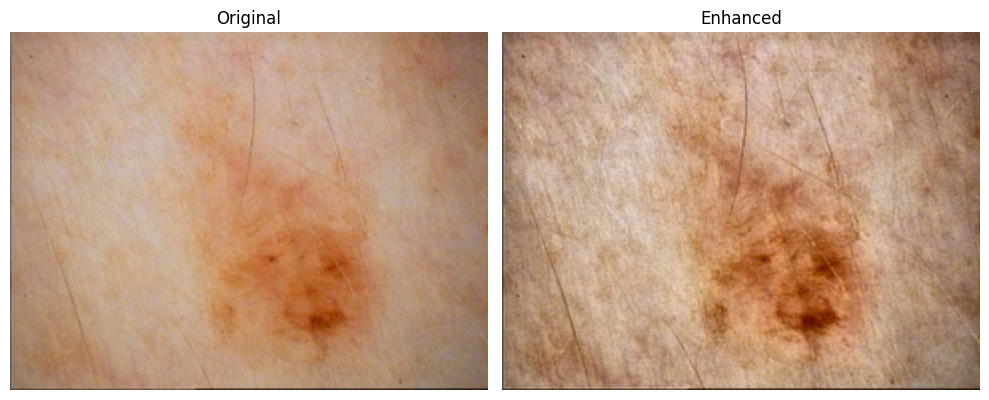

In [ ]:
apply_clahe_to_image(input_image, output_image,clip_limit=2)
show_images(input_image, output_image)

## Utility function for displaying images

In [30]:
import cv2
import matplotlib.pyplot as plt

def show_images(img1_path, img2_path, title1="Original", title2="Enhanced"):
    # Load images
    img1 = cv2.imread(img1_path)
    img2 = cv2.imread(img2_path)

    # Convert from BGR to RGB
    img1_rgb = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
    img2_rgb = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

    # Get dimensions
    h1, w1 = img1.shape[:2]
    h2, w2 = img2.shape[:2]

    # Plot side-by-side
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(img1_rgb)
    plt.title(f"{title1}\n{w1}x{h1}px")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(img2_rgb)
    plt.title(f"{title2}\n{w2}x{h2}px")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

# Example usage:
# show_images("/content/ISIC_9648278.jpg", "/content/enhanced_color_3.jpg")
